In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Replace `path` with directory where your `face_images` were downloaded.

In [2]:
import os, random
path = '/home/nonsodono/Documents/face_images'
os.chdir(path)  

### Converting Data to Fastai's `DataBlock` objects.

In [3]:
!pip3 install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import *

/home/nonsodono/CV_Projects/cv_env/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
/home/nonsodono/CV_Projects/cv_env/lib/python3.9/site-packages/fastbook/__init__.py:18: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [4]:
faces = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.15, seed=42),
    get_y=parent_label
    )

In [5]:
dls = faces.dataloaders(path)

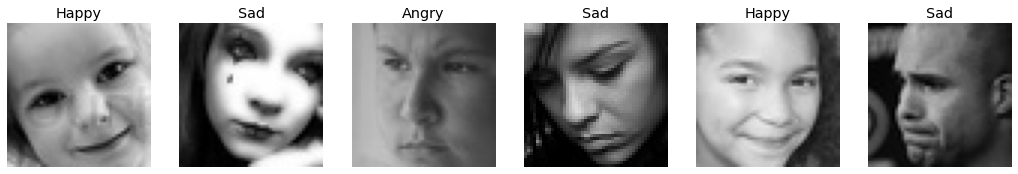

In [6]:
dls.train.show_batch(max_n=6, nrows=1)

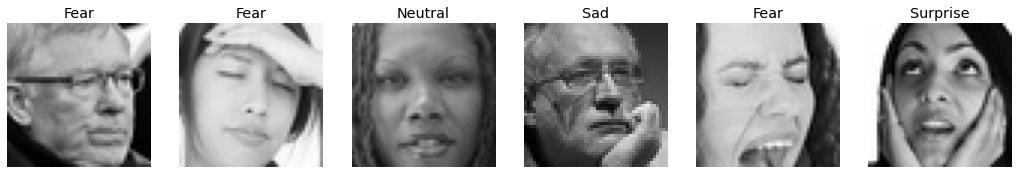

In [7]:
dls.valid.show_batch(max_n=6, nrows=1)

### Data Augmentation

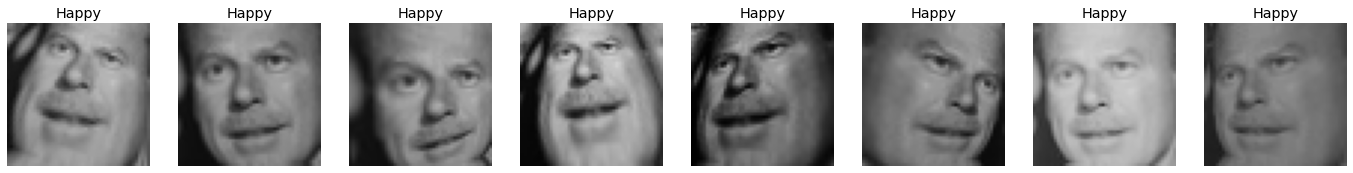

In [8]:
faces = faces.new(item_tfms=Resize(48), batch_tfms=aug_transforms(mult=2))
dls = faces.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=1, unique=True)

### Training the model using Fastai and `vgg19_bn` pretrained model

In [9]:
model = cnn_learner(dls, vgg19_bn, metrics=accuracy)
model.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,2.046695,1.749323,0.343626,09:49


epoch,train_loss,valid_loss,accuracy,time
0,1.614890,1.391389,0.473918,16:42
1,1.359312,1.232504,0.524444,14:16
2,1.241463,1.135346,0.571930,13:21
3,1.175012,1.040616,0.619883,12:30
4,1.090581,1.029185,0.616374,12:35
5,1.036249,0.973334,0.639532,12:31
6,0.984340,0.955996,0.651930,12:29
7,0.931837,0.948235,0.654269,12:29
8,0.898526,0.932237,0.666667,12:33
9,0.853060,0.942456,0.660117,12:59


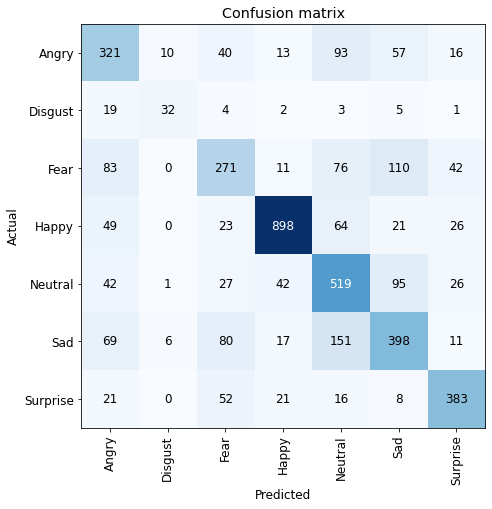

In [10]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix(figsize=(7,7))

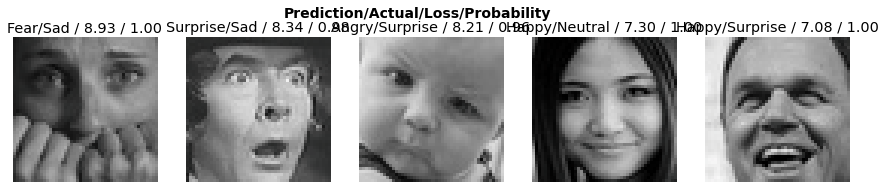

In [11]:
interp.plot_top_losses(5, nrows=1)

### Cleaning the data based on loss data.

In [12]:
cleaner = ImageClassifierCleaner(model)
cleaner

In [13]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), str(path/cat).split('.')[0] + "_fixed.jpg")

### Exporting the model 

In [14]:
model.export()

In [15]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### Make `inferences` from the loaded model

In [16]:
model_inf = load_learner(path/'export.pkl')

In [17]:
# Show classes in the model
model_inf.dls.vocab

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

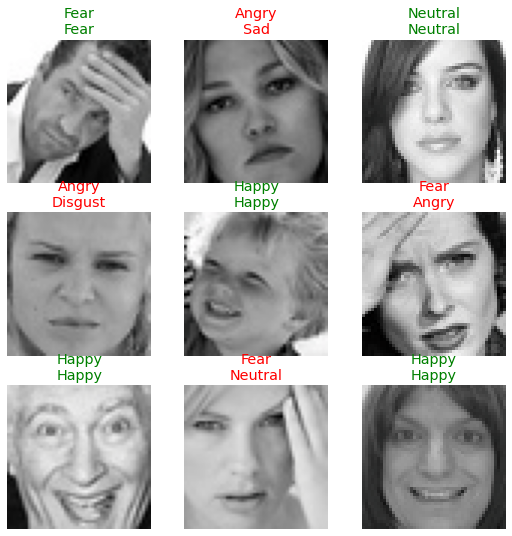

In [18]:
model.show_results()

In [19]:
### Add widgets to upload and classify example images

In [20]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = model_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [21]:
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select your face!'), 
      btn_upload, btn_run, out_pl, lbl_pred])